## Introdução

O Sistema de Informações Hospitalares do Sistema Único de Saúde (SIH/SUS) constitui uma das principais bases administrativas de saúde do Brasil, reunindo registros de internações hospitalares financiadas pelo SUS em todo o território nacional. Essas informações são fundamentais para o monitoramento da morbidade hospitalar, da utilização dos serviços de saúde e para o apoio à formulação de políticas públicas baseadas em evidências.

O conjunto de dados **SIH/SUS – Admissões Hospitalares por Municípios (2024)**, disponibilizado no Kaggle, permite a análise das internações ocorridas ao longo do ano de 2024, com foco no nível municipal. A natureza quantitativa dessas informações possibilita a aplicação de métodos estatísticos apropriados para dados de contagem, com destaque para os Modelos Lineares Generalizados.


## O Banco de Dados

O banco de dados é derivado do **SIH/SUS**, cujas informações são coletadas por meio das **Autorizações de Internação Hospitalar (AIH)**. Cada AIH corresponde a uma internação e contém dados clínicos, demográficos e administrativos relacionados ao atendimento hospitalar.

Neste dataset, os registros foram agregados por município, contemplando variáveis como número de internações, óbitos hospitalares, dias de permanência, utilização de UTI e características institucionais das unidades de saúde. Essa estrutura permite comparações espaciais entre municípios e regiões, além da investigação de padrões de utilização dos serviços hospitalares do SUS.


## Modelagem Estatística (GLM)

A variável resposta principal — número de admissões hospitalares — é caracterizada como **dado de contagem**, assumindo valores inteiros não negativos. Nesse contexto, a análise é conduzida por meio de **Modelos Lineares Generalizados (GLM)**, que permitem modelar a relação entre a variável resposta e um conjunto de covariáveis explicativas.

Inicialmente, pode-se empregar a distribuição **Poisson**, adequada para modelagem de contagens sob a suposição de igualdade entre média e variância. Contudo, devido à heterogeneidade regional e à variabilidade observada nos dados de saúde, é comum a ocorrência de **sobredispersão**, tornando a **Binomial Negativa** uma alternativa mais apropriada. Essas abordagens possibilitam a identificação de fatores associados às admissões hospitalares e a avaliação de diferenças entre municípios.


In [105]:
import kagglehub
import pandas as pd

# Download latest version
#path = kagglehub.dataset_download("andersonfranca/sistema-de-informaes-hospitalares-sus")


# df = pd.read_csv(
#    "RD202412.csv",
#    sep=";",
#    encoding="latin1",
#    low_memory=False
# )


df_pb_filtrado = pd.read_csv(
    "df_pb_filtrado.csv",
    sep=",",
    encoding="latin1",
    low_memory=False
)




A priori vamos selecionar algumas variáveis que serão de extremo interesse na análise descritiva e posterior ajuste do modelo **glm**, lemrbando    que estamos interessados em estimar **Contagem de internações** com base nas covariáveis como UF, mês, especialidade, idade.......

In [48]:
print(df_pb_filtrado.columns.tolist())

['UF_ZI', 'ANO_CMPT', 'MES_CMPT', 'ESPEC', 'CGC_HOSP', 'N_AIH', 'IDENT', 'CEP', 'MUNIC_RES', 'NASC', 'SEXO', 'UTI_MES_IN', 'UTI_MES_AN', 'UTI_MES_AL', 'UTI_MES_TO', 'MARCA_UTI', 'UTI_INT_IN', 'UTI_INT_AN', 'UTI_INT_AL', 'UTI_INT_TO', 'DIAR_ACOM', 'QT_DIARIAS', 'PROC_SOLIC', 'PROC_REA', 'VAL_SH', 'VAL_SP', 'VAL_SADT', 'VAL_RN', 'VAL_ACOMP', 'VAL_ORTP', 'VAL_SANGUE', 'VAL_SADTSR', 'VAL_TRANSP', 'VAL_OBSANG', 'VAL_PED1AC', 'VAL_TOT', 'VAL_UTI', 'US_TOT', 'DT_INTER', 'DT_SAIDA', 'DIAG_PRINC', 'DIAG_SECUN', 'COBRANCA', 'NATUREZA', 'NAT_JUR', 'GESTAO', 'RUBRICA', 'IND_VDRL', 'MUNIC_MOV', 'COD_IDADE', 'IDADE', 'DIAS_PERM', 'MORTE', 'NACIONAL', 'NUM_PROC', 'CAR_INT', 'TOT_PT_SP', 'CPF_AUT', 'HOMONIMO', 'NUM_FILHOS', 'INSTRU', 'CID_NOTIF', 'CONTRACEP1', 'CONTRACEP2', 'GESTRISCO', 'INSC_PN', 'SEQ_AIH5', 'CBOR', 'CNAER', 'VINCPREV', 'GESTOR_COD', 'GESTOR_TP', 'GESTOR_CPF', 'GESTOR_DT', 'CNES', 'CNPJ_MANT', 'INFEHOSP', 'CID_ASSO', 'CID_MORTE', 'COMPLEX', 'FINANC', 'FAEC_TP', 'REGCT', 'RACA_COR', '

In [106]:


import pandas as pd
from pandas.api.types import CategoricalDtype

df_pb_filtrado["IDADE"] = (
    pd.to_datetime(
        df_pb_filtrado["ANO_CMPT"].astype(str)
        + df_pb_filtrado["MES_CMPT"].astype(str).str.zfill(2)
        + "01",
        format="%Y%m%d"
    )
    - pd.to_datetime(df_pb_filtrado["NASC"].astype(str), format="%Y%m%d", errors="coerce")
).dt.days // 365

df_pb_filtrado[["IDADE"]].head()
df_pb_filtrado = df_pb_filtrado[df_pb_filtrado["IDADE"].between(0, 120)]


import pandas as pd

# Garantir que é string e remover espaços
df_pb_filtrado['DIAG_PRINC'] = df_pb_filtrado['DIAG_PRINC'].astype(str).str.strip()

# Extrair primeira letra
df_pb_filtrado['CID_LETRA'] = df_pb_filtrado['DIAG_PRINC'].str[0]

# Mapeamento oficial por capítulos CID-10
mapa_capitulos = {
    'A': 'I - Infecciosas e parasitárias',
    'B': 'I - Infecciosas e parasitárias',
    'C': 'II - Neoplasias',
    'D': 'II - Neoplasias / Doenças hematológicas',
    'E': 'IV - Endócrinas, nutricionais e metabólicas',
    'F': 'V - Transtornos mentais e comportamentais',
    'G': 'VI - Sistema nervoso',
    'H': 'VII/VIII - Olho e ouvido',
    'I': 'IX - Aparelho circulatório',
    'J': 'X - Aparelho respiratório',
    'K': 'XI - Aparelho digestivo',
    'L': 'XII - Pele e tecido subcutâneo',
    'M': 'XIII - Sistema osteomuscular',
    'N': 'XIV - Sistema geniturinário',
    'O': 'XV - Gravidez, parto e puerpério',
    'P': 'XVI - Afecções perinatais',
    'Q': 'XVII - Malformações congênitas',
    'R': 'XVIII - Sintomas e sinais',
    'S': 'XIX - Lesões e envenenamentos',
    'T': 'XIX - Lesões e envenenamentos',
    'V': 'XX - Causas externas',
    'W': 'XX - Causas externas',
    'X': 'XX - Causas externas',
    'Y': 'XX - Causas externas',
    'Z': 'XXI - Fatores que influenciam o estado de saúde',
    'U': 'XXII - Códigos especiais'
}

df_pb_filtrado['CID_CAPITULO'] = df_pb_filtrado['CID_LETRA'].map(mapa_capitulos)

# Opcional: tratar códigos inválidos
df_pb_filtrado['CID_CAPITULO'] = df_pb_filtrado['CID_CAPITULO'].fillna('Não classificado')


def classificar_gravidade(capitulo):
    
    baixa = [
        'XV - Gravidez, parto e puerpério',
        'XII - Pele e tecido subcutâneo',
        'XIII - Sistema osteomuscular',
        'XXI - Fatores que influenciam o estado de saúde'
    ]
    
    intermediaria = [
        'X - Aparelho respiratório',
        'XI - Aparelho digestivo',
        'XIV - Sistema geniturinário',
        'XVIII - Sintomas e sinais',
        'VI - Sistema nervoso',
        'V - Transtornos mentais e comportamentais'
    ]
    
    alta = [
        'IX - Aparelho circulatório',
        'II - Neoplasias',
        'I - Infecciosas e parasitárias',
        'XIX - Lesões e envenenamentos',
        'XX - Causas externas',
        'XVI - Afecções perinatais'
    ]
    
    if capitulo in baixa:
        return 1
    elif capitulo in intermediaria:
        return 2
    elif capitulo in alta:
        return 3
    else:
        return 2  # default intermediário

df_pb_filtrado['CID_GRAVIDADE'] = df_pb_filtrado['CID_CAPITULO'].apply(classificar_gravidade)


# ===============================
# 1. Seleção de variáveis
# ===============================

cols = [
    "ESPEC",
    "IND_VDRL",
    "IDADE",
    "CAR_INT",
    "DIAS_PERM",
    "MARCA_UTI",
    "INSTRU",
    "CONTRACEP1",
    "MORTE",
    "CID_GRAVIDADE"
]

df_pb_filtrado = df_pb_filtrado[cols].copy()

# ===============================
# 2. Conversão de tipos
# ===============================
#INSTRU_ORDERED = CategoricalDtype(ordered=True, categories=["0", "1", "2", "3", "4", "0;9"])

df_pb_filtrado = df_pb_filtrado.astype({
    "ESPEC": "category",
    "CID_GRAVIDADE": "category",
    "IND_VDRL": "category",
    "CAR_INT": "category",
    "MARCA_UTI": "category",
    "INSTRU": "category",
    "CONTRACEP1": "category",
    "IDADE": float,
    "DIAS_PERM": int,
    "MORTE": "category"
})

# ===============================
# 3. Remover valores faltantes
# ===============================

df_pb_filtrado = df_pb_filtrado.dropna()

#df_pb_filtrado = df_pb_filtrado.convert_dtypes()



Os dados apresentados na tabela a seguir descrevem as variáveis disponíveis no conjunto de dados **SIH/SUS – Admissões Hospitalares por Municípios (2024)**. Cada variável possui uma classificação quanto ao tipo dado, natureza e seu uso potencial em análises baseadas em Modelos Lineares Generalizados (GLM). Essas informações são essenciais para compreender a estrutura do banco de dados e orientar as análises subsequentes.

| Variável      | Tipo de dado       | Natureza     |  caracterísitica                                   |
| ------------- | ------------------ | ------------ |  ------------------------------------------------- |
| **IDADE**     | Contínua           | Quantitativa |  Tempo em anos                                     |
| **IND_VDRL**  | Categórica nominal | Qualitativa  | Indica exame VDRL (positivo/negativo) infecção sexualmente transmissível causada pela bactéria Treponema pallidum.)             |
| **ESPEC**     | Categórica nominal | Qualitativa  |  Especialidade do leito                            |
| **ESTRU**     | Categórica ordinal | Qualitativa  | Grau de instrução/escolaridade do paciente                            |
| **CONTRACEP1**   | Categórica nominal | Qualitativa  |  Tipo de contraceptivo utilizado                             |
| **CAR_INT**   | Categórica nominal | Qualitativa  | Caráter da internação  (eletivo, Urgencia,...,Outros tipos de lesões e envenentos por agente químicos e físicos)                           |
| **MARCA_UTI** | Categórica nominal | Qualitativa  | Indica qual o tipo de UTI utilizada pelo paciente |
| **MORTE**     | Categória nominal          | Qualitativa  |  Indica óbito                                      |
| **DIAS_PERM** | Discreta           | Quantitativa |  Dias de Permanência total de dias de internação   |



### Importância das Medidas Descritivas

As medidas descritivas são utilizadas para caracterizar a estrutura das variáveis do estudo. Variáveis numéricas, como idade e dias de permanência, são descritas por medidas de tendência central, dispersão e amplitude, permitindo resumir sua distribuição.

Variáveis categóricas, como sexo, raça/cor, características de internação, marca de UTI e morte, são descritas por meio de frequências absolutas e relativas, possibilitando a compreensão da distribuição das categorias.

In [108]:
# Estatísticas descritivas com skewness e kurtosis
tabela_descritiva = df_pb_filtrado.describe(include="all").round(2)
# Aplique o estilo
tabela_descritiva.style.format("{:.2f}") \
                       .set_caption("Estatísticas Descritivas") \
                       #.background_gradient()

,ESPEC,IND_VDRL,IDADE,CAR_INT,DIAS_PERM,MARCA_UTI,INSTRU,CONTRACEP1,MORTE,CID_GRAVIDADE
count,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00,10692.00
unique,8.00,2.00,nan,4.00,nan,8.00,5.00,6.00,2.00,3.00
top,1.00,0.00,nan,2.00,nan,0.00,0.00,0.00,0.00,2.00
freq,4032.00,9272.00,nan,8414.00,nan,9647.00,10467.00,10467.00,10060.00,4043.00
mean,nan,nan,43.51,nan,5.33,nan,nan,nan,nan,nan
std,nan,nan,24.25,nan,6.51,nan,nan,nan,nan,nan
min,nan,nan,0.00,nan,0.00,nan,nan,nan,nan,nan
25%,nan,nan,25.00,nan,2.00,nan,nan,nan,nan,nan
50%,nan,nan,41.00,nan,3.00,nan,nan,nan,nan,nan
75%,nan,nan,63.00,nan,7.00,nan,nan,nan,nan,nan


### Entendo a distribuição dos dados via 

O PAIR PLOT é uma ferramenta gráfica que permite visualizar a distribuição de uma variável numérica, destacando sua mediana, quartis e possíveis valores atípicos. Ele é útil para identificar a dispersão dos dados, a presença de outliers e a simetria ou assimetria da distribuição. No contexto dos dados analisados, o boxplot pode ser utilizado para explorar variáveis como **IDADE** e **DIAS_PERM**, fornecendo insights sobre a variação e padrões dessas variáveis em relação às categorias de interesse

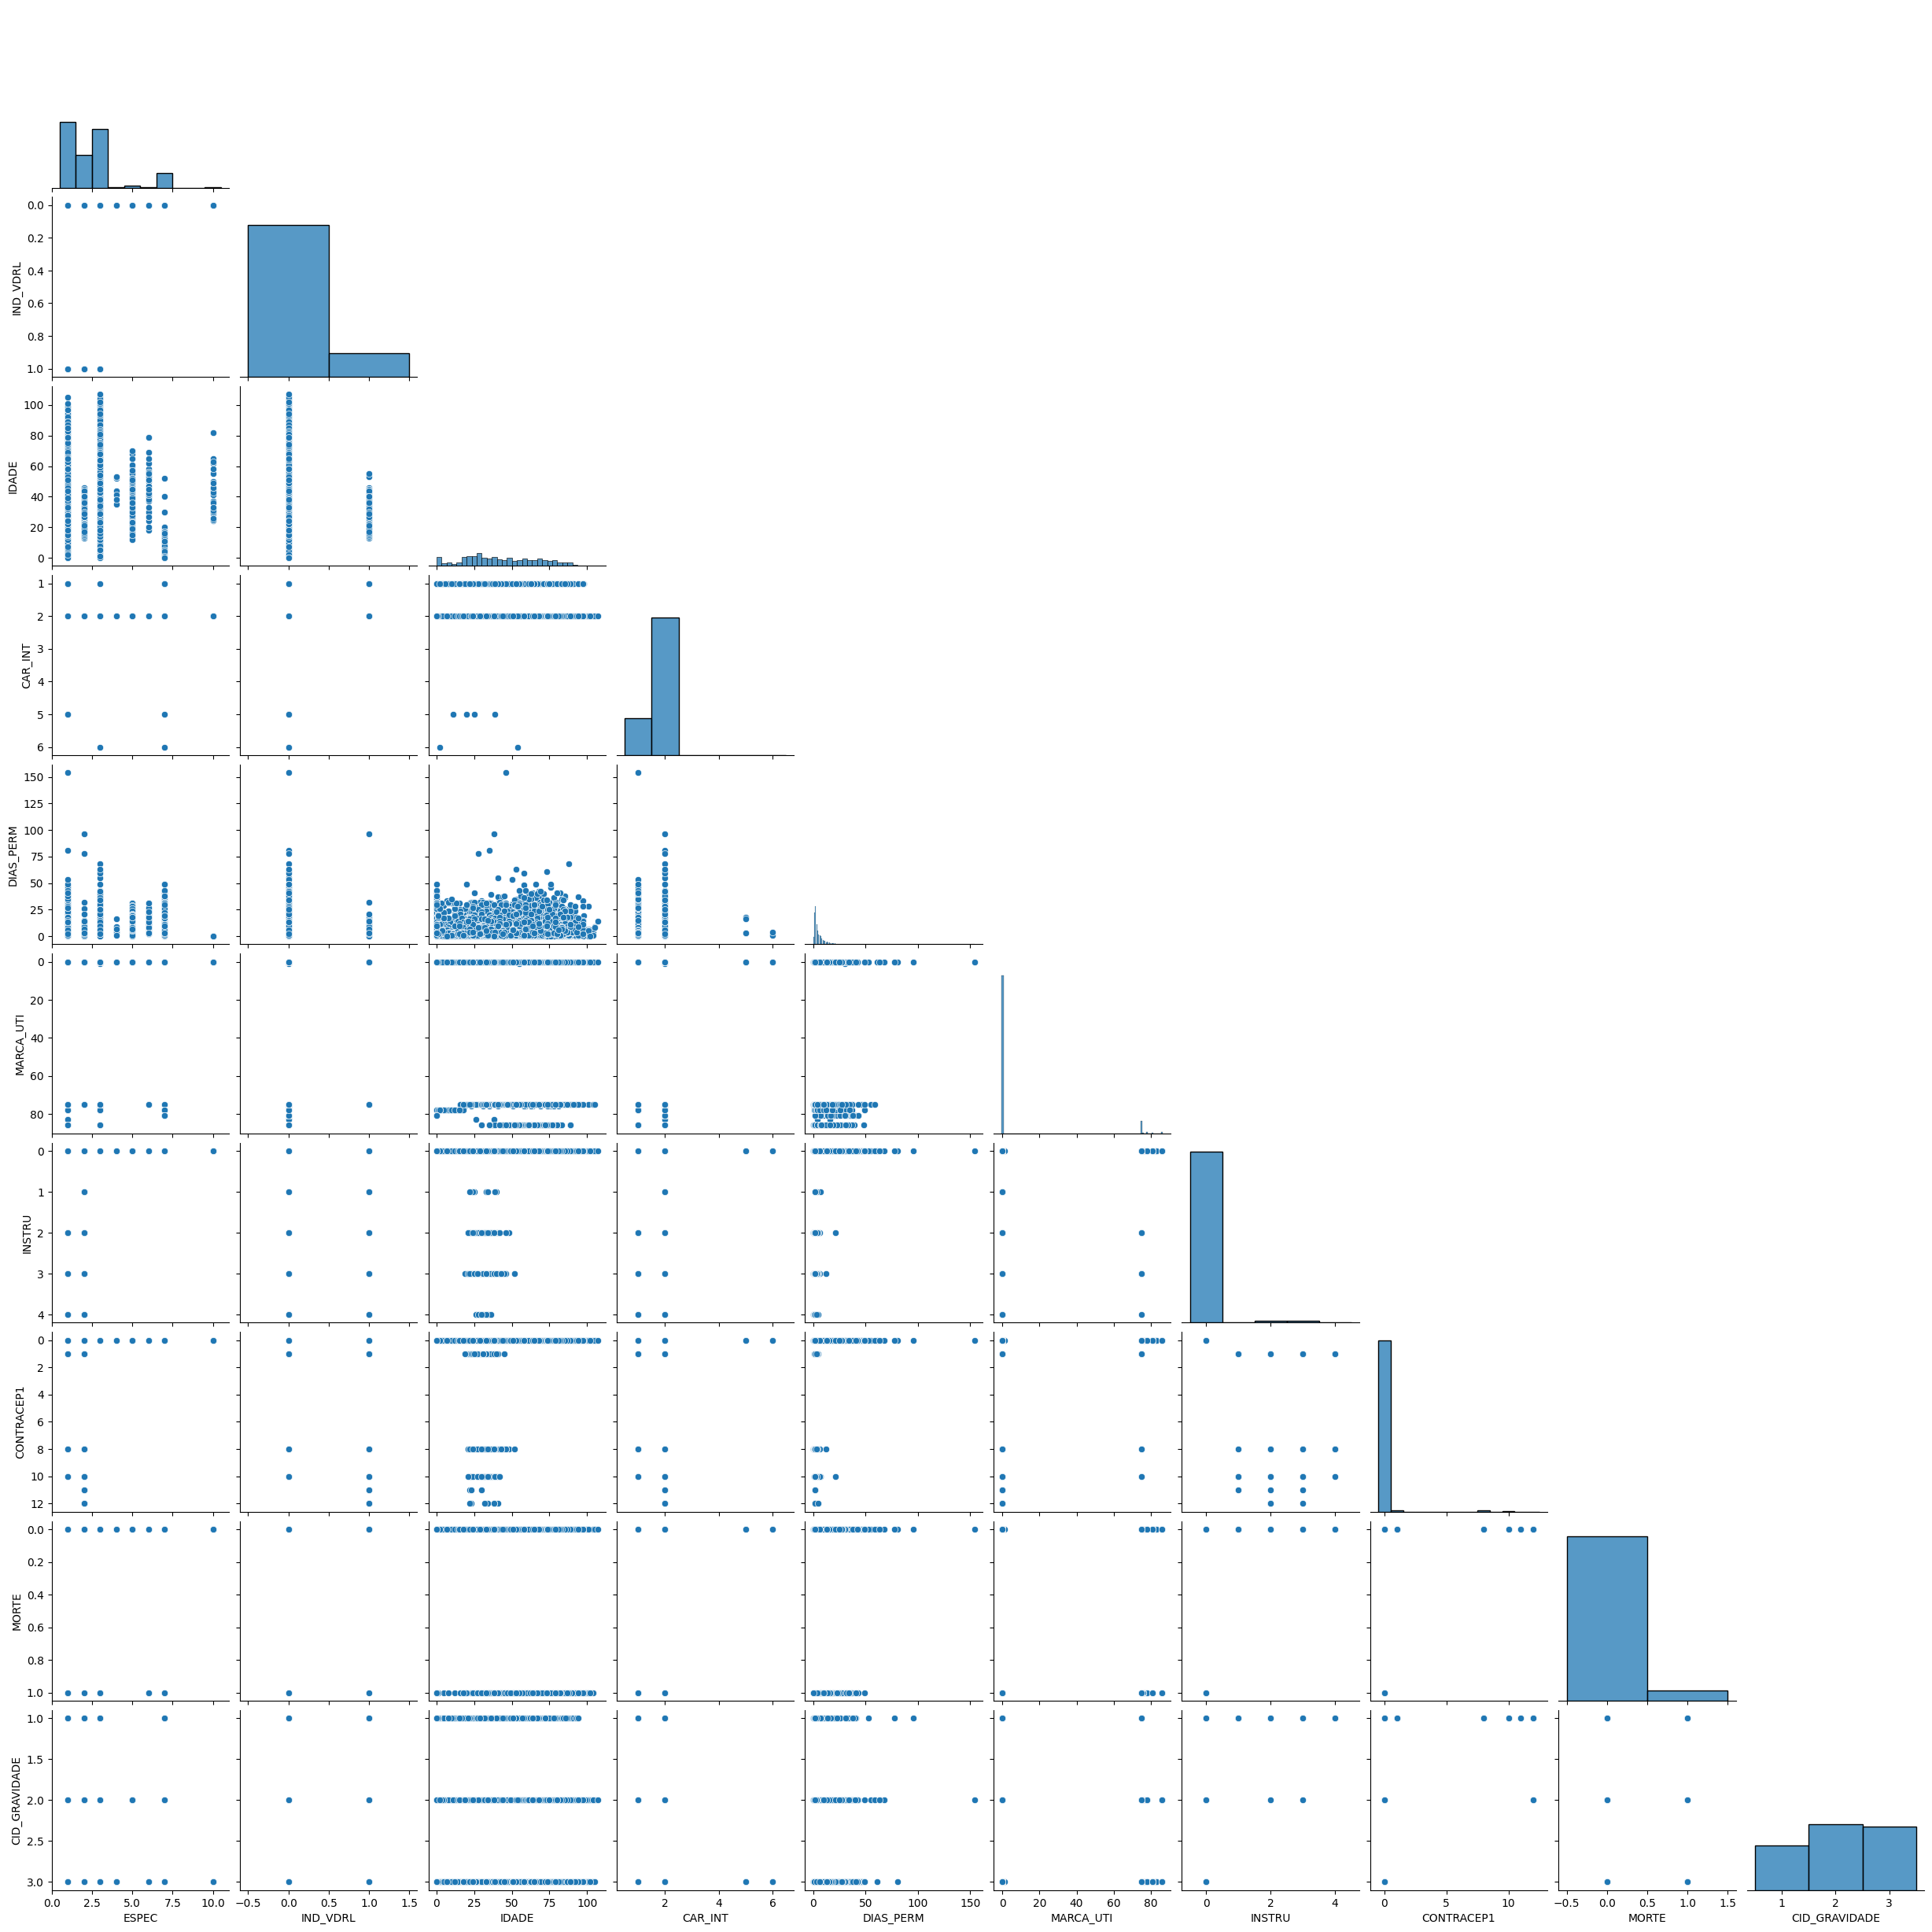

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# fig, axes = plt.subplots(4, 2, figsize=(12, 8))
# axes = axes.flatten()

# for idx, col in enumerate(["ESPEC", "IDADE", "SEXO", 'RACA_COR', "CAR_INT", "DIAS_PERM", "MARCA_UTI", "MORTE"]):
#     sns.boxplot(y=df_pb_filtrado[col], ax=axes[idx])
#     axes[idx].set_title(f'Boxplot - {col}')
#     # remover apenas o texto do rótulo Y
#     axes[idx].set_ylabel('')

# plt.tight_layout()
# plt.show()

#df_pb = sns.load_dataset("df_pb_filtrado")
#plt.figure(figsize=(20, 20))
sns.pairplot(df_pb_filtrado, vars=[
    "ESPEC",
    "IND_VDRL",
    "IDADE",
    "CAR_INT",
    "DIAS_PERM",
    "MARCA_UTI",
    "INSTRU",
    "CONTRACEP1",
    "MORTE", 
    'CID_GRAVIDADE'],
    corner=True,
    )


1. **IDADE e DIAS_PERM**: Observa-se uma distribuição de pontos que sugere uma possível relação positiva entre a idade e o número de dias de permanência hospitalar. Pacientes mais idosos tendem a permanecer mais tempo internados.

2. **Variáveis Categóricas**: As representações das variáveis categóricas mostram a distribuição de frequências entre as categorias. É possível observar concentrações em determinadas categorias (representadas por densidade maior de pontos), indicando distribuições desbalanceadas.

3. **MORTE vs outras variáveis**: A distribuição da variável resposta (**MORTE**) em relação às covariáveis revela padrões diferenciados:
    - Pacientes que faleceram (categoria 1) tendem a ter maior idade em comparação com os que sobreviveram
    - A distribuição nos dias de permanência também mostra diferenças entre os grupos

4. **Relações entre variáveis categóricas**: As sobreposições entre categorias das variáveis qualitativas indicam associações que podem ser exploradas no modelo GLM, particularmente **CAR_INT** (Caráter da Internação) e **MARCA_UTI** (uso de UTI), que parecem mostrar padrões estruturados.

5. **Padrão geral**: O pairplot evidencia que a maioria das observações está distribuída em valores baixos de tecnologia de UTI e dias de permanência mais curtos, sugerindo que internações de baixa complexidade são predominantes na base de dados, enquanto casos com maior complexidade (UTI, permanência prolongada) representam minorias.
6. **ESPEC (Especialidade)**: O boxplot mostra a distribuição das especialidades médicas. Como é uma variável categórica, os valores representam diferentes categorias de especialidades. A altura das caixas indica a frequência relativa de cada categoria.

7. **IDADE**: O boxplot da idade apresenta a distribuição etária dos pacientes. A mediana (linha central da caixa) indica a idade mediana, enquanto os quartis mostram a dispersão dos dados. Valores atípicos (outliers) podem ser observados como pontos fora dos limites do boxplot, indicando pacientes com idades muito altas ou muito baixas.

8. **SEXO**: Sendo uma variável categórica, o boxplot do sexo reflete a distribuição entre os gêneros. As categorias podem representar masculino e feminino, e a altura das caixas indica a frequência relativa de cada gênero.

9. **RACA_COR (Raça/Cor)**: Este boxplot apresenta a distribuição das categorias de raça/cor. A maioria dos registros parece estar concentrada em uma ou duas categorias, indicando predominância de determinados grupos raciais.

10. **CAR_INT (Características de Internação)**: O boxplot desta variável categórica mostra a distribuição das características de internação, como gravidade ou tipo de atendimento. A altura das caixas reflete a frequência relativa de cada categoria.

11. **DIAS_PERM (Dias de Permanência)**: O boxplot dos dias de permanência hospitalar mostra a variação no tempo de internação dos pacientes. A mediana e os quartis indicam a tendência central e a dispersão, enquanto os outliers podem indicar internações excepcionalmente longas.

12. **MARCA_UTI (Marca de UTI)**: Este boxplot reflete a distribuição das categorias relacionadas ao uso de UTI. A maioria dos registros parece estar concentrada em uma categoria específica, indicando que a maioria dos pacientes não utilizou UTI.

13. **MORTE**: O boxplot da variável morte, sendo binária, mostra a distribuição entre pacientes que sobreviveram e aqueles que faleceram. A altura das caixas reflete a frequência relativa de cada categoria.

### Relações lineares entre variáveis numéricas
 A matriz de correlação de Spearman entre as variáveis numéricas do dataset. O objetivo é identificar relações lineares fortes que possam informar próximas etapas (e.g., seleção de variáveis, multicolinearidade, ou insights de causa/efeito possível).

Pontos importantes:
- O coeficiente de Pearson varia de -1 a 1; 1 indica correlação positiva perfeita, -1 correlação negativa perfeita, e 0 nenhuma correlação linear.
- Correlação não implica causalidade: use estes resultados apenas como sinalizadores.
- Atenção a colinearidade: variáveis fortemente correlacionadas podem distorcer modelos que supõem independência entre variáveis (e.g., regressão).

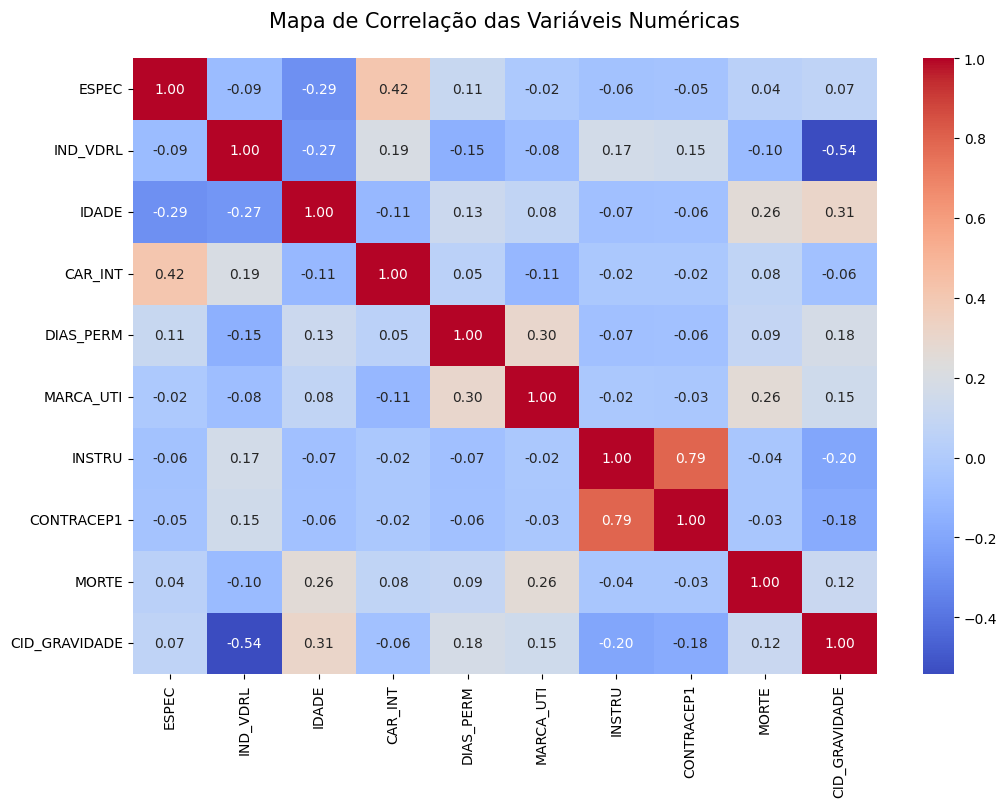

In [111]:
from scipy.stats import pearsonr

# # # Gráfico de correlação entre todas as variáveis numéricas do DataFrame dados_titanic1
# plt.figure(figsize=(12,8))
# corr = df_pb_filtrado.corr(numeric_only=False, method = "spearman")
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('matrix de correlações entre variáveis numéricas')
# # calcular p-values de Pearson para cada par de variáveis
# cols = corr.columns.tolist()
# pvals = pd.DataFrame(np.nan, index=cols, columns=cols)

# for i in range(len(cols)):
#     for j in range(len(cols)):
#         x = df_pb_filtrado[cols[i]]
#         y = df_pb_filtrado[cols[j]]
#         mask = x.notna() & y.notna()
#         if mask.sum() > 2:
#             _, p = spearmanr(x[mask], y[mask])
#         else:
#             p = np.nan
#         pvals.iloc[i, j] = p

# # função para transformar p-value em estrelas de significância
# def sig_stars(p):
#     if pd.isna(p):
#         return ''
#     if p < 0.001:
#         return '***'
#     if p < 0.01:
#         return '**'
#     if p < 0.05:
#         return '*'
#     return ''

# # anotar estrelas de significância sobre o heatmap
# ax = plt.gca()
# n = len(cols)
# for i in range(n):
#     for j in range(n):
#         star = sig_stars(pvals.iloc[i, j])
#         if star:
#             # posicionar a estrela levemente acima do número da correlação
#             ax.text(j + 0.5, i + 0.28, star, ha='center', va='center', color='black', fontsize=14)

# plt.show()

# # Heatmap# p
plt.figure(figsize=(12,8))
sns.heatmap(df_pb_filtrado.corr(numeric_only=False), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('matrix de correlações entre variáveis numéricas')
plt.title("Mapa de Correlação das Variáveis Numéricas\n", fontsize = 15)
plt.show()

Diante das variáveis selecionadas, optou-se por prosseguir as análises sem a variável **ESPEC**, uma vez que ela se encontra fortemente correlacionada com **CAR_INT** assim como **CONTRACEP1** vs **INSTRU**, optou-se por proceseguir com **INSTRU**. Considerando essa elevada correlação, manteve-se no modelo apenas as demais variáveis, a fim de evitar problemas de multicolinearidade e possíveis distorções nas estimativas.

In [7]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import pandas as pd

# X = df_pb_filtrado.drop(columns=['MORTE'])  # remove a variável dependente
# # Calcular VIF para cada variável
# vif_data = pd.DataFrame()
# vif_data["Variável"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# print(vif_data)


In [128]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#df_pb_filtrado["MORTE"] = df_pb_filtrado["MORTE"].astype(int)
#print(df_pb_filtrado["MORTE"].value_counts())

modelo = smf.glm(
    formula="MORTE ~ IDADE + C(MARCA_UTI) + C(CID_GRAVIDADE)+ C(CAR_INT) + C(ESPEC)",
    data=df_pb_filtrado,
    family=sm.families.Binomial(link=sm.families.links.Logit())
).fit()

print(modelo.summary())

#resumo = logit.summary(xname=["intercepto", "Classe femínina", "Idade"]); resumo
#resumo.as_latex_tabular()
#logit.mle_retvals


                    Generalized Linear Model Regression Results                     
Dep. Variable:     ['MORTE[0]', 'MORTE[1]']   No. Observations:                10692
Model:                                  GLM   Df Residuals:                    10671
Model Family:                      Binomial   Df Model:                           20
Link Function:                        Logit   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -1646.1
Date:                      seg, 16 fev 2026   Deviance:                       3292.2
Time:                              17:36:58   Pearson chi2:                 1.08e+04
No. Iterations:                          24   Pseudo R-squ. (CS):             0.1316
Covariance Type:                  nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [125]:
#logit.params
from matplotlib.pylab import exp #ou
import numpy as np
exp(modelo.conf_int(alpha=0.05)).round(3)


C:\Users\fabia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


,0,1
Intercept,1153.710,5254.865
C(MARCA_UTI)[T.1],0.000,inf
C(MARCA_UTI)[T.75],0.081,0.126
C(MARCA_UTI)[T.76],0.033,0.214
C(MARCA_UTI)[T.78],0.013,0.087
C(MARCA_UTI)[T.81],0.003,0.088
C(MARCA_UTI)[T.83],0.000,inf
C(MARCA_UTI)[T.86],0.089,0.338
C(CID_GRAVIDADE)[T.2],0.164,0.609
C(CID_GRAVIDADE)[T.3],0.191,0.710


In [126]:
np.exp(modelo.params). round(3)

Intercept                2.462233e+03
C(MARCA_UTI)[T.1]        9.062275e+09
C(MARCA_UTI)[T.75]       1.010000e-01
C(MARCA_UTI)[T.76]       8.300000e-02
C(MARCA_UTI)[T.78]       3.400000e-02
C(MARCA_UTI)[T.81]       1.700000e-02
C(MARCA_UTI)[T.83]       1.033297e+09
C(MARCA_UTI)[T.86]       1.740000e-01
C(CID_GRAVIDADE)[T.2]    3.160000e-01
C(CID_GRAVIDADE)[T.3]    3.680000e-01
C(CAR_INT)[T.2]          4.840000e-01
C(CAR_INT)[T.5]          3.449069e+08
C(CAR_INT)[T.6]          1.807414e+09
C(ESPEC)[T.2]            6.481000e+00
C(ESPEC)[T.3]            2.750000e-01
C(ESPEC)[T.4]            1.741490e+09
C(ESPEC)[T.5]            1.547662e+09
C(ESPEC)[T.6]            1.840000e-01
C(ESPEC)[T.7]            1.585000e+00
C(ESPEC)[T.10]           1.737856e+09
IDADE                    9.620000e-01
dtype: float64

### Por que utilizar a função `exp` para interpretar os intervalos de confiança?

No modelo de regressão logística, os coeficientes estimados (coef) estão na escala de log-odds (logaritmo das chances). Essa escala não é diretamente interpretável em termos de probabilidades ou razões de chances (odds ratio). Para interpretar os coeficientes de forma mais intuitiva, é necessário transformá-los de volta para a escala de odds, o que é feito aplicando a função exponencial (`exp`).

- Aplicando a função `exp`, temos:
    - `exp(0.0513) ≈ 1.0513`
    - `exp(-0.1353) ≈ 0.873`
- O odds ratio para **IDADE** é 1.0513, com um intervalo de confiança de [1.048, 1.057]. Isso significa que, para cada ano adicional de idade, a chance de óbito aumenta em aproximadamente 5.13%, com o aumento variando entre 4.8% e 5.7% com 95% de confiança.
- O odds ratio para **SEXO** é 0.873, com um intervalo de confiança de [0.738, 1.033]. Isso significa que, em relação a categoria de base (sexo masculino), a chance de óbito diminui em aproximadamente 12,7%, variando entre 2.62% e 3.33% com 95% de confiança.


C:\Users\fabia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:521: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / np.sqrt(1 - self.hat_matrix_diag)


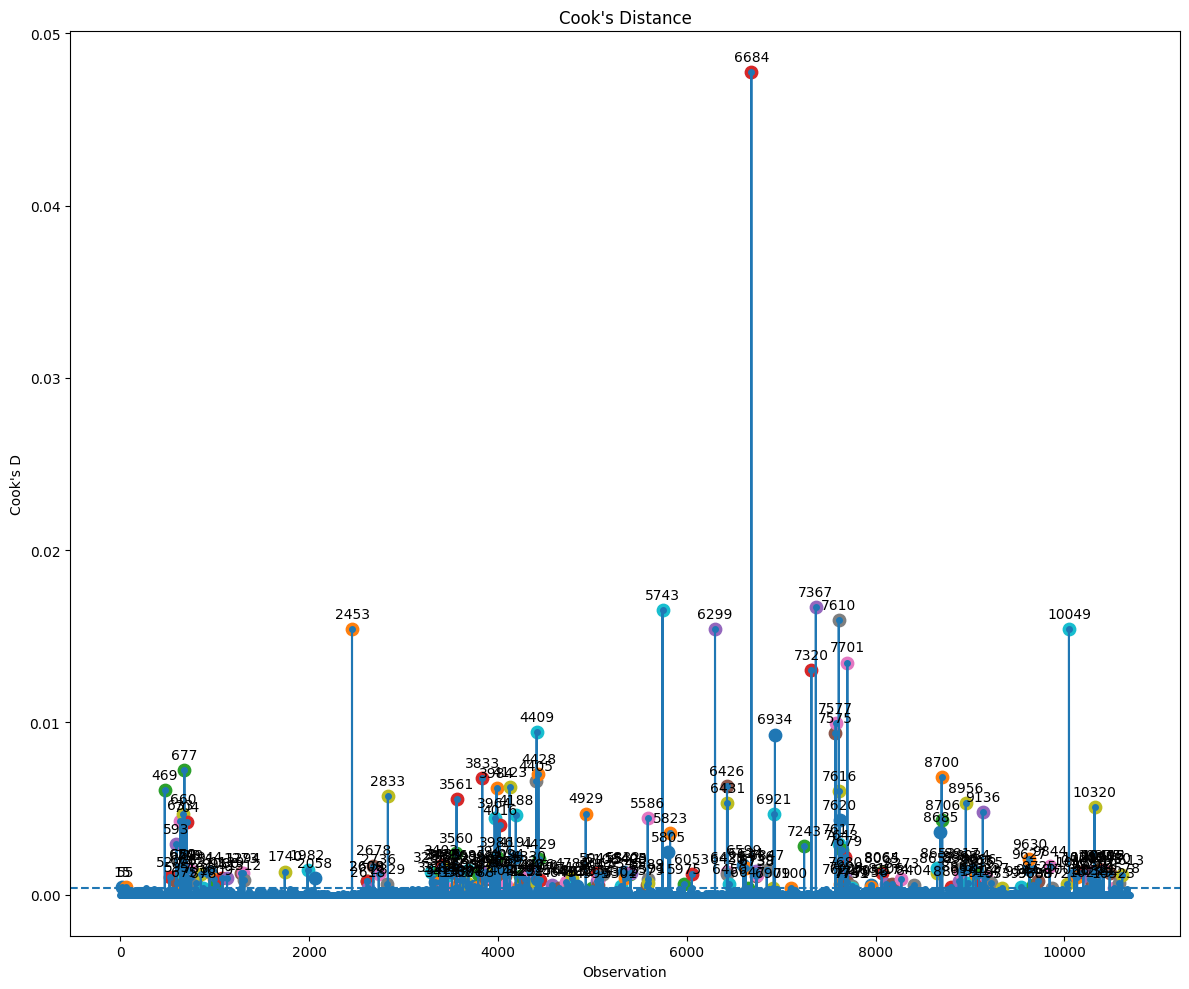

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# Dados
y = modelo.model.endog
p = modelo.predict()

# Evita problemas numéricos
p = np.clip(p, 1e-8, 1 - 1e-8)

# Pearson residuals
resid_pearson = (y - p) / np.sqrt(p * (1 - p))

# Deviance residuals
resid_deviance = np.sign(y - p) * np.sqrt(
    -2 * (y * np.log(p) + (1 - y) * np.log(1 - p))
)

# Influência
influence = modelo.get_influence()
hat_values = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# ===========================
# Painel 2x2
# ===========================

#fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# # 1️⃣ Deviance residuals
# ax[0, 0].scatter(p, resid_deviance)
# ax[0, 0].axhline(0, linestyle='--')
# ax[0, 0].set_title("Deviance Residuals vs Fitted")
# ax[0, 0].set_xlabel("Fitted probabilities")
# ax[0, 0].set_ylabel("Deviance residuals")

# # 2️⃣ Pearson residuals
# ax[0, 1].scatter(p, resid_pearson)
# ax[0, 1].axhline(0, linestyle='--')
# ax[0, 1].set_title("Pearson Residuals vs Fitted")
# ax[0, 1].set_xlabel("Fitted probabilities")
# ax[0, 1].set_ylabel("Pearson residuals")

# # 3️⃣ Leverage
# ax[1, 0].scatter(p, hat_values)
# ax[1, 0].set_title("Leverage vs Fitted")
# ax[1, 0].set_xlabel("Fitted probabilities")
# ax[1, 0].set_ylabel("Leverage")

# 4️⃣ Cook’s Distance
fig, ax = plt.subplots(1, figsize=(12, 10))
n = len(y)
threshold = 4 / n

influential_points = np.where(cooks_d > threshold)[0]

plt.plot(cooks_d, linestyle='-', marker='o', markersize=4)
plt.axhline(threshold, linestyle='--')

for i in influential_points:
    plt.scatter(i, cooks_d[i], s=80)
    plt.annotate(
        str(i),
        (i, cooks_d[i]),
        textcoords="offset points",
        xytext=(0,8),
        ha='center'
    )

plt.title("Cook's Distance")
plt.xlabel("Observation")
plt.ylabel("Cook's D")
plt.tight_layout()
plt.show()


In [132]:

influence = modelo.get_influence()
cooks_d = influence.cooks_distance[0]
hat_values = influence.hat_matrix_diag

resid_deviance = np.sign(y - p) * np.sqrt(
    -2 * (y * np.log(p) + (1 - y) * np.log(1 - p))
)

n = len(y)
k = modelo.df_model  # número de preditores

# Critérios
cook_cut = 4 / n
lev_cut = 2 * (k + 1) / n

idx_cook = np.where(cooks_d > cook_cut)[0]
idx_lev = np.where(hat_values > lev_cut)[0]
idx_res = np.where(np.abs(resid_deviance) > 2)[0]

# União dos índices problemáticos
idx_problem = np.unique(
    np.concatenate([idx_cook, idx_lev, idx_res])
)

print("Total de observações conflitantes:", len(idx_problem))


Total de observações conflitantes: 901


C:\Users\fabia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:521: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / np.sqrt(1 - self.hat_matrix_diag)


In [133]:
df_pb_filtrado = df_pb_filtrado.drop(index=6684)
modelo = smf.glm(
    formula="MORTE ~ IDADE + C(MARCA_UTI) + C(CID_GRAVIDADE)+ C(CAR_INT) + C(ESPEC)",
    data=df_pb_filtrado,
    family=sm.families.Binomial(link=sm.families.links.Logit())
).fit()

print(modelo.summary())



                    Generalized Linear Model Regression Results                     
Dep. Variable:     ['MORTE[0]', 'MORTE[1]']   No. Observations:                10691
Model:                                  GLM   Df Residuals:                    10670
Model Family:                      Binomial   Df Model:                           20
Link Function:                        Logit   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -1645.2
Date:                      seg, 16 fev 2026   Deviance:                       3290.5
Time:                              17:39:57   Pearson chi2:                 1.08e+04
No. Iterations:                          24   Pseudo R-squ. (CS):             0.1317
Covariance Type:                  nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------